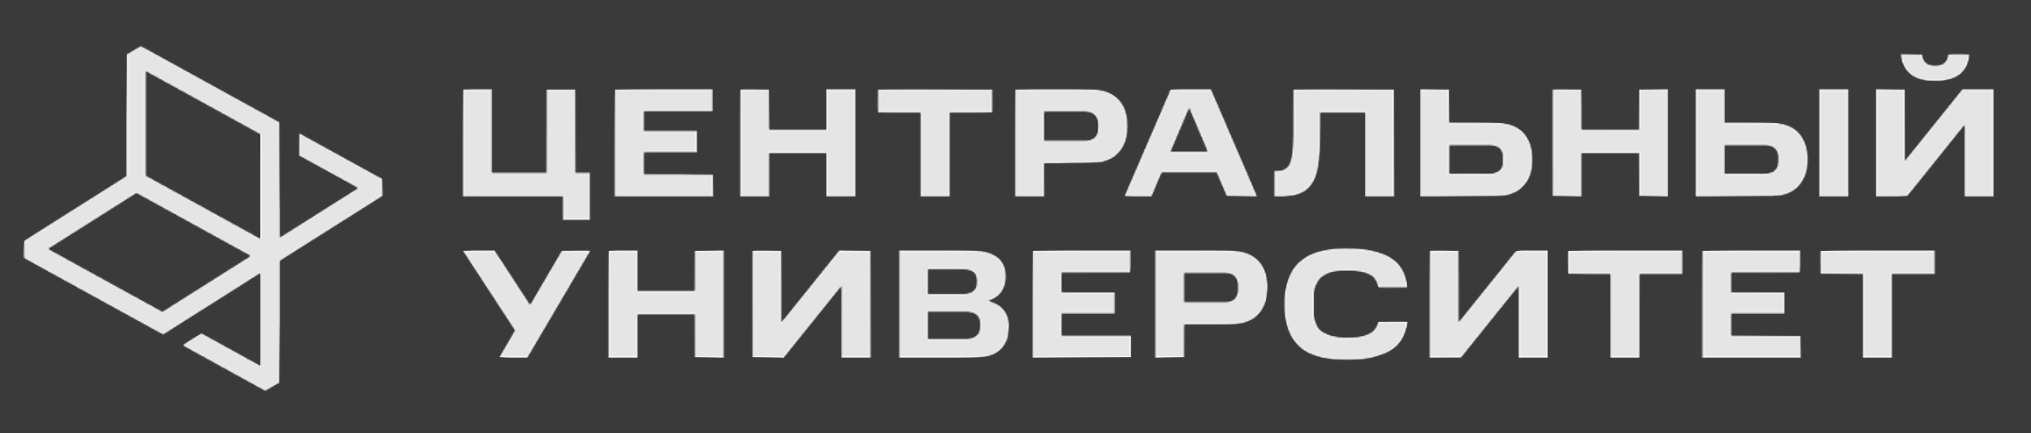

# Домашнее задание 8. Generative models.

## Максимальное кол-во баллов: 100

___
## Cроки

Дата выдачи: TBD

Жесткий дедлайн: TBD



---

# Важно! О формате сдачи

* **При решении ноутбука используйте данный шаблон. Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно**
* **Везде, где в формулровке задания есть какой-либо вопрос (или просьба вывода), необходимо прописать ответ в ячейку (код или markdown).**
* **Наличие кода решения обязательно. Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.**
*  **Если в ячейке написана фраза "Вывод"/"Ответ на вопрос"/"Ваш текст" и пр., то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно).**
* **Если в ячейке написано "Your code here"/"Ваш код" и пр., то ожидается ответ в виде кода (можете добавить больше ячеек с кодом, если считаете это необходимым, но это необязательно).**
* **Если есть и ячейка с фразой "Вывод" и пр., и ячейка с фразой "Your code here" и пр., то в ответе ожидается и код, и текст)**
* **Если в формулировке задания явно не указывается сигнатура функции, можно пользоваться своими методами**
___


Привет! В этой домашке тебе предстоит подчинить себе генерацию, а именно реализовать conditional-варианты архитектур VAE/GAN

**Важно**:
1. архитектуры должны быть реализованы при помощи сверточных слоев `nn.Conv2d`, решения без сверток засчитываться не будут, но можно добавлять `nn.Linear` по необходимости
2. чекпоинты, ноутбук и используемые модули(архитектуры рекомендуется разбить на модули для читаемости) должны быть прикреплены к решению
3. можешь оставить requirements.txt чтобы облегчить проверяющим жизнь

---

## <font color='orange'>Задание 0: Данные [5 баллов]</font>



```
# This is formatted as code
```

Работать будем с хорошо известным вам датасетом циферок, ниже его надо будет скачать при помощи `torchvision API`

![](https://user-images.githubusercontent.com/47734496/60438108-8b894000-9c2d-11e9-9cbb-1c06e3fb90a7.png)

Размер картинок: 28x28x1, трейн/тест сплиты: 60000, 10000

Лики данных допустимы, можете использовать все данные как трейн, только оставьте какую-то часть на валидацию(понадобится для графиков функций потерь)

---

### 0.1. [5 баллов]
### Формулировка задания:

1. Визуализируй семплы из датесетов для твоего:
- трейна
- инференса
2. Выведи размеры train/val сплитов


Нормализовывать картинки не обязательно, используй референсы ниже как пример

In [ ]:
from torchvision import transforms
transforms = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor()
])

In [ ]:
from torchvision.datasets import MNIST

train_dataset = MNIST(root='mnist_dataset', train=True, transform=transforms, download=True)
val_dataset = MNIST(root='mnist_dataset', train=False, transform=transforms, download=True)

len(train_dataset), len(val_dataset)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.46MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.13MB/s]


(60000, 10000)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_transforms(dataset, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))

    for i in range(num_images):
        img, label = dataset[i]

        img = img.numpy().squeeze()

        axes[i].imshow(img, cmap='Blues')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.show()


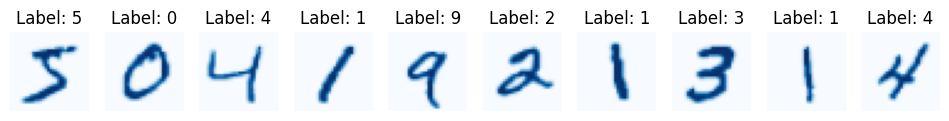

In [ ]:
show_transforms(train_dataset, num_images=10)

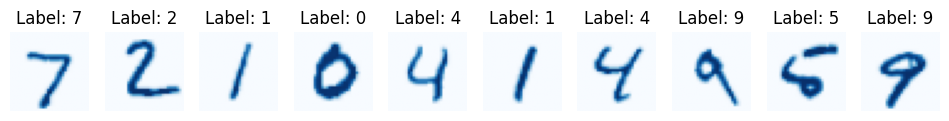

In [ ]:
show_transforms(val_dataset, num_images=10)

---

## <font color='orange'>Задание 1: Conditional VAE [45 баллов] + 5 баллов за функцию метрики</font>

![](https://drive.google.com/uc?export=view&id=1-GQwHMBFpY8W1hiOO_yuIOh8yfcAox6D)

![](https://drive.google.com/uc?export=view&id=1DIAUPy88plSiuA8n9ElkLnmg8nTd-vuH)

Note: подумай как еще можно закодировать лейблы с помощью `nn.Embedding` вместо `one-hot`-представления. Скорее всего, так будет лучше учиться

---

### 1.1. [10 баллов]
### Формулировка задания:

Реализуй conditional-автоэнкодер, можешь использовать картинку выше как референс, не запрещается использовать более интересные подходы

Артефактом к данному пункту будет служить модуль с автоэнкодером или клетка с объявлением класса

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CVAE(nn.Module):
    def __init__(self, num_classes=10, z_dim=20):
        super(CVAE, self).__init__()

        self.num_classes = num_classes
        self.z_dim = z_dim

        self.label_emb_dim = 10
        self.label_emb = nn.Embedding(num_classes, self.label_emb_dim)

        self.enc_conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.enc_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.enc_fc = nn.Linear(64*8*8 + self.label_emb_dim, 2 * z_dim)

        self.dec_fc = nn.Linear(z_dim + self.label_emb_dim, 64*8*8)

        self.dec_deconv1 = nn.ConvTranspose2d(in_channels=64, out_channels=32,
                                              kernel_size=4, stride=2, padding=1, output_padding=0)
        self.dec_deconv2 = nn.ConvTranspose2d(in_channels=32, out_channels=1,
                                              kernel_size=4, stride=2, padding=1, output_padding=0)

    def encode(self, x, y):
        h = F.relu(self.enc_conv1(x))
        h = F.relu(self.enc_conv2(h))

        h = h.view(h.size(0), -1)

        y_emb = self.label_emb(y)

        h = torch.cat([h, y_emb], dim=1)

        h = self.enc_fc(h)
        mu, logvar = torch.chunk(h, 2, dim=1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        y_emb = self.label_emb(y)
        h = torch.cat([z, y_emb], dim=1)
        h = self.dec_fc(h)
        h = h.view(h.size(0), 64, 8, 8)
        h = F.relu(self.dec_deconv1(h))
        h = torch.sigmoid(self.dec_deconv2(h))

        return h

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, y)
        return x_recon, mu, logvar


---

### 1.2. [5 баллов]
### Формулировка задания:

Обучи модель и визуализируй историю лоссов по эпохам на train/val сплитах(вторая картинка на референсе необязательная)

Должно получиться что-то похожее на референсную картинку ниже

Артефакт: веса обученной модели

In [ ]:
import torch
from torch.utils.data import DataLoader

def cvae_loss_function(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld

def train_autoencoder(model, train_loader, val_loader, epochs=5, lr=1e-3, device="cuda"):
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            x_recon, mu, logvar = model(x, y)
            loss = cvae_loss_function(x_recon, x, mu, logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                x_recon, mu, logvar = model(x, y)
                val_loss = cvae_loss_function(x_recon, x, mu, logvar)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs+1), train_losses, label="Train Loss", marker="o")
    plt.plot(range(1, epochs+1), val_losses, label="Validation Loss", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss")
    plt.show()


Epoch [1/30] - Train Loss: 185.2850 - Val Loss: 155.3728
Epoch [2/30] - Train Loss: 153.3610 - Val Loss: 150.4350
Epoch [3/30] - Train Loss: 150.2360 - Val Loss: 148.1142
Epoch [4/30] - Train Loss: 148.4146 - Val Loss: 147.1266
Epoch [5/30] - Train Loss: 147.2086 - Val Loss: 146.0756
Epoch [6/30] - Train Loss: 146.2697 - Val Loss: 144.8146
Epoch [7/30] - Train Loss: 145.5590 - Val Loss: 144.8959
Epoch [8/30] - Train Loss: 145.0104 - Val Loss: 143.7230
Epoch [9/30] - Train Loss: 144.4886 - Val Loss: 143.9537
Epoch [10/30] - Train Loss: 144.1352 - Val Loss: 143.6371
Epoch [11/30] - Train Loss: 143.7907 - Val Loss: 143.2445
Epoch [12/30] - Train Loss: 143.5315 - Val Loss: 142.8799
Epoch [13/30] - Train Loss: 143.2660 - Val Loss: 142.6495
Epoch [14/30] - Train Loss: 143.0111 - Val Loss: 142.5120
Epoch [15/30] - Train Loss: 142.8098 - Val Loss: 142.1466
Epoch [16/30] - Train Loss: 142.6525 - Val Loss: 142.3634
Epoch [17/30] - Train Loss: 142.4395 - Val Loss: 142.0650
Epoch [18/30] - Train L

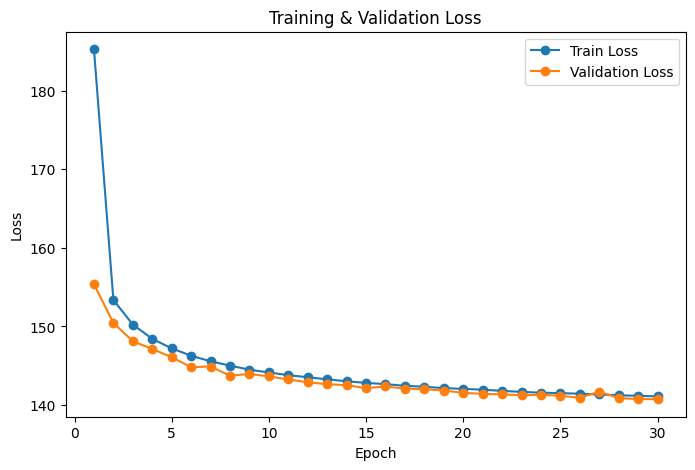

In [ ]:
batch_size = 64
lr = 1e-3
epochs = 30
z_dim = 20

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE(num_classes=10, z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_autoencoder(
    model, train_loader, val_loader, epochs=epochs, lr=lr)

In [ ]:
torch.save(model.state_dict(), 'cvae.ckpt')

---

### 1.3. [5 баллов]
### Формулировка задания:

1. Реализуй функцию `show_grid_vae(...)`, используя шаблон ниже

2. Визуализируй результат для `digit=4, n_reps=9`

3. Добавь код загрузки весов обученной модели, чтобы проверяющему было удобно воспроизвести твой код

In [ ]:
import matplotlib.pyplot as plt
import torch

@torch.no_grad()
def show_grid_vae(model=None, digit=0, n_reps=1, device=None):
    model.eval()
    labels = torch.full((n_reps,), digit, dtype=torch.long, device=device)
    z = torch.randn(n_reps, model.z_dim, device=device)
    generated_images = model.decode(z, labels)
    generated_images = generated_images.cpu().numpy()
    generated_images = generated_images.clip(0, 1)
    grid_size = int(n_reps ** 0.5)
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))
    axes = axes.ravel()

    for i in range(n_reps):
        axes[i].imshow(generated_images[i, 0], cmap='gray')
        axes[i].axis('off')

    plt.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load('cvae.ckpt', map_location=device)

model = CVAE(num_classes=10, z_dim=20).to(device)
model.load_state_dict(checkpoint)

<All keys matched successfully>

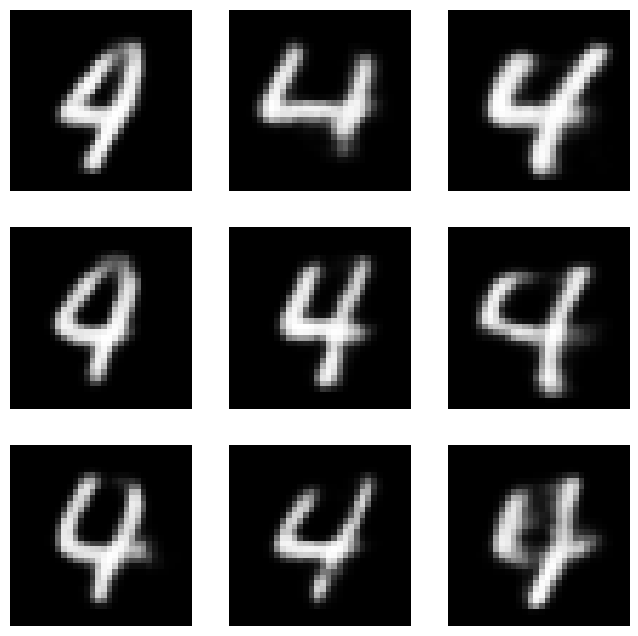

In [ ]:
show_grid_vae(
    model=model,
    digit=4,
    n_reps=9,
    device=device
)

---

### 1.4. [25 баллов] + 5 баллов за корректную реализацию функции из п.п. 1
### Формулировка задания:

1. Реализуй функцию `compute_acc_vae(...)`, используя шаблон ниже

2. Выведи результат для `n_reps=100`

Итоговый балл за этот пункт рассчитывается по формуле:

- int(mean_acc * 25), где mean_acc лежит в [0, 1]


In [ ]:
import torch.nn as nn
from collections import OrderedDict


class LeNet5(nn.Module):
    """
    Input - 1x32x32
    C1 - 6@28x28 (5x5 kernel)
    tanh
    S2 - 6@14x14 (2x2 kernel, stride 2) Subsampling
    C3 - 16@10x10 (5x5 kernel, complicated shit)
    tanh
    S4 - 16@5x5 (2x2 kernel, stride 2) Subsampling
    C5 - 120@1x1 (5x5 kernel)
    F6 - 84
    tanh
    F7 - 10 (Output)
    """
    def __init__(self):
        super(LeNet5, self).__init__()

        self.convnet = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=(5, 5))),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu3', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c5', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('relu5', nn.ReLU())
        ]))

        self.fc = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('relu6', nn.ReLU()),
            ('f7', nn.Linear(84, 10)),
            ('sig7', nn.LogSoftmax(dim=-1))
        ]))

    def forward(self, img):
        output = self.convnet(img)
        output = output.view(img.size(0), -1)
        output = self.fc(output)
        return output

In [ ]:
import torchvision.transforms as TT
import torch

classifier_model = LeNet5().eval()
classifier_model.load_state_dict(torch.load('lenet_epoch=12_test_acc=0.991.pth', weights_only=True))
classifier_model = classifier_model.to(device)

In [ ]:
import torch
import torch.nn.functional as F

@torch.no_grad()
def compute_acc_vae(model=None, n_reps=1, device=None):
    model.eval()
    classifier_model.eval()

    accuracies = []

    for digit in range(10):
        labels = torch.full((n_reps,), digit, dtype=torch.long, device=device)
        z = torch.randn(n_reps, model.z_dim, device=device)
        generated_images = model.decode(z, labels)
        outputs = classifier_model(generated_images)
        _, predicted_labels = torch.max(outputs, 1)

        correct_predictions = (predicted_labels == labels).sum().item()
        accuracy = correct_predictions / n_reps
        accuracies.append(accuracy)

    mean_accuracy = torch.mean(torch.tensor(accuracies, device=device)).item()
    std_accuracy = torch.std(torch.tensor(accuracies, device=device)).item()

    return mean_accuracy, std_accuracy

In [ ]:
mu, sigma = compute_acc_vae(
    model=model,
    n_reps=100,
    device=device
)

mu, sigma

(0.9699999690055847, 0.019999997690320015)

---

## <font color='orange'>Задание 2: Conditional GAN [45 баллов]</font>

![](https://drive.google.com/uc?export=view&id=1k0C7KI6hOrCuOpa4UmZMNPy2wnjZpaBO)

---

### 2.1. [10 баллов]
### Формулировка задания:

Реализуй conditional-GAN, можешь использовать картинку выше как референс, не запрещается использовать более интересные подходы

Артефактом к данному пункту будет служить модуль с автоэнкодером или клетка с объявлением класса

In [ ]:
# "Your code here"

---

### 2.2. [5 баллов]
### Формулировка задания:

Обучи модель и визуализируй историю лоссов генератора и дискриминатора по эпохам(вторая и третья картинки на референсе необязательные)

Должно получиться что-то похожее на референсную картинку ниже

Артефакт: веса обученной модели

In [ ]:
# "Your code here"

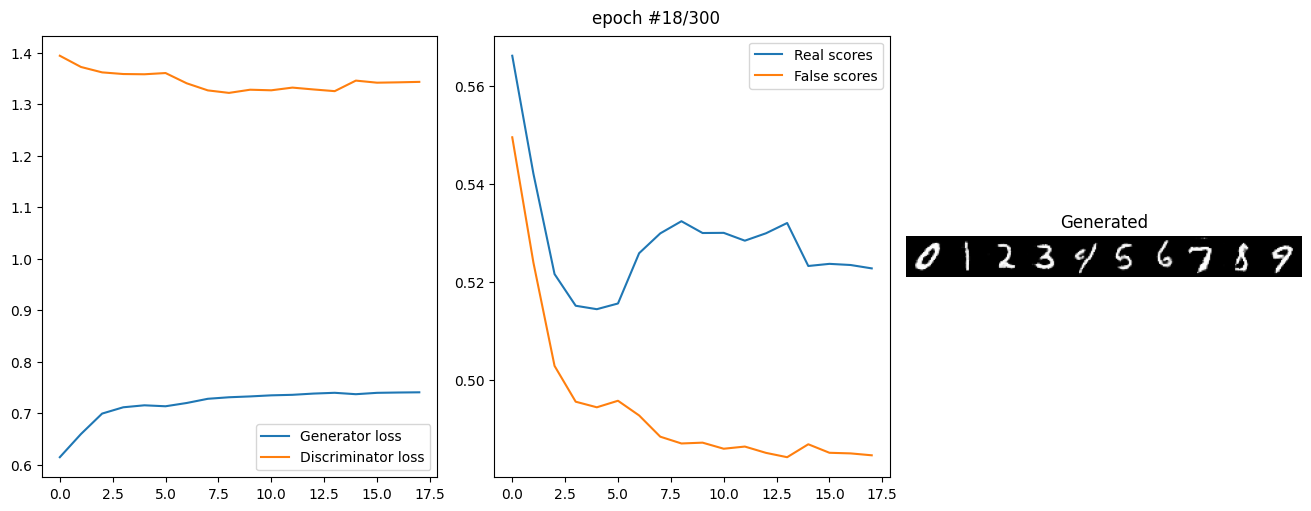

batch iterations:   0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
losses_g, losses_d, real_scores, fake_scores = train_gan(
    model=model,
    loader=train_loader,
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=300,
    device=DEVICE,
    log_step=1
)

In [ ]:
# torch.save(generator.state_dict(), 'cgan.ckpt')

---

### 2.3. [5 баллов]
### Формулировка задания:

1. Реализуй функцию `show_grid_gan(...)`, используя шаблон ниже

2. Визуализируй результат для `digit=8, n_reps=9`

3. Добавь код загрузки весов обученной модели, чтобы проверяющему было удобно воспроизвести твой код

In [ ]:
@torch.no_grad
def show_grid_gan(model=None, digit=0, n_reps=1, device=None):
    """
    Визуализатор семлов CGAN.
            Параметры:
                    model torch.nn.Module: модель CVAE
                    digit (int): генерируемая цифра
                    n_reps (int): кол-во семплов
                    device torch.device: девайс
            Возвращаемое значение:
                    None
    """
    # "Your code here"

In [ ]:
# "Your code here"

Пример:

In [ ]:
checkpoint = torch.load('cgan.ckpt', map_location='cpu')

model = Generator(
    latent_dim=LATENT_DIM,
    num_channels=NUM_CHANNELS,
    num_filters=NUM_FILTERS,
    num_classes=NUM_CLASSES
)
model.load_state_dict(checkpoint)

<All keys matched successfully>

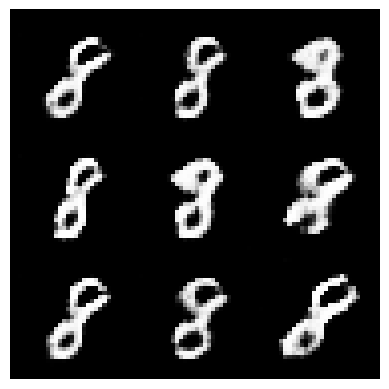

In [ ]:
show_grid_gan(
    model,
    digit=8,
    n_reps=9,
    device=DEVICE
)

---

### 2.4. [25 баллов]
### Формулировка задания:

1. Реализуй функцию ```compute_acc_gan(...)```, используя шаблон ниже

2. Выведи результат для `n_reps=100`

Итоговый балл за этот пункт рассчитывается по формуле:

- int(mean_acc * 25), где mean_acc лежит в [0, 1]

In [ ]:
import torchvision.transforms as TT
from lenet import LeNet5
import torch

classiffier_model = LeNet5().eval()
classiffier_model.load_state_dict(torch.load('lenet_epoch=12_test_acc=0.991.pth', weights_only=True))
classiffier_model = classiffier_model.to(device)

transform = TT.Compose([
    TT.Resize(size=(32, 32), antialias=True)
])

In [ ]:
@torch.no_grad
def compute_acc_gan(model=None, n_reps=1, device=None):
    """
    CGAN accuracy.
    Алгоритм:
        1. цикл по цифрам
            a. генерируем n_reps цифр с одинаковым лейблом D
            b. считаем accuracy классификатора classiffier_model (в идеале все предикты должны быть D)
            с. сохраняем результат усредненной метрики в буфер

        2. Считаем (mean, std) для получившегося буфера
        3. Возвращаем (mean, std)

            Параметры:
                    model torch.nn.Module: модель CVAE
                    n_reps (int): кол-во семплов
                    device torch.device: девайс
            Возвращаемое значение:
                    (mean, std) (float, float) рассчитаные по цифрам
    """

    # "Your code here"

In [ ]:
# "Your code here"

<All keys matched successfully>

In [ ]:
mu, sigma = compute_acc_gan(
    model=model,
    n_reps=100,
    device=DEVICE
)

mu, sigma

  0%|          | 0/10 [00:00<?, ?it/s]

(0.9259999999999999, 0.15882065356873457)

---